# Step 1: Loading the CSV file.

In [ ]:
import pandas as pd

df = pd.read_csv(r'C:\Users\ga28\Downloads\test.csv')

In [18]:
!pip install textblob

     -------------------------------------- 624.3/624.3 kB 4.9 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 12.0 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


In [12]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  2191 non-null   object
 1   body     2191 non-null   object
 2   date     2191 non-null   object
 3   from     2191 non-null   object
dtypes: object(4)
memory usage: 68.6+ KB


# Step 2: Sentiment Labeling.

## Step 2.1: Convert  to datetime format

In [14]:
df['date'] = pd.to_datetime(df['date'])

## Step 2.2: Apply Sentiment Analysis

In [22]:
from textblob import TextBlob

def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment'] = df['body'].apply(get_sentiment)

## Step 2.3: View the Results

In [23]:
df[['body', 'Sentiment']].head(10)

,body,Sentiment
0,EnronOptions Announcement\n\n\nWe have updated...,Positive
1,"Marc,\n\nUnfortunately, today is not going to ...",Neutral
2,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",Neutral
3,we were thinking papasitos (we can meet somewh...,Negative
4,Since you never gave me the $20 for the last t...,Neutral
5,"sure, just call me the bank that delivers.\n \...",Positive
6,Inventory summaries for both MGL and MGMCC as ...,Neutral
7,Please print attachment and make sure that e:m...,Positive
8,Please advise me of your interest in Garvin's ...,Positive
9,The start time for Tuesday morning has been ch...,Positive


# Step 3: Exploratory Data Analysis (EDA)

## Step 3.1: Sentiment Distribution Plot

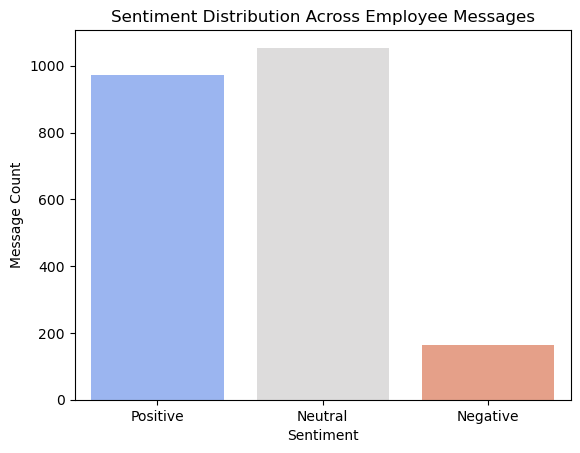

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='Sentiment', palette='coolwarm')
plt.title('Sentiment Distribution Across Employee Messages')
plt.xlabel('Sentiment')
plt.ylabel('Message Count')
plt.show()

## Step 3.2: Sentiment Trend Over Time

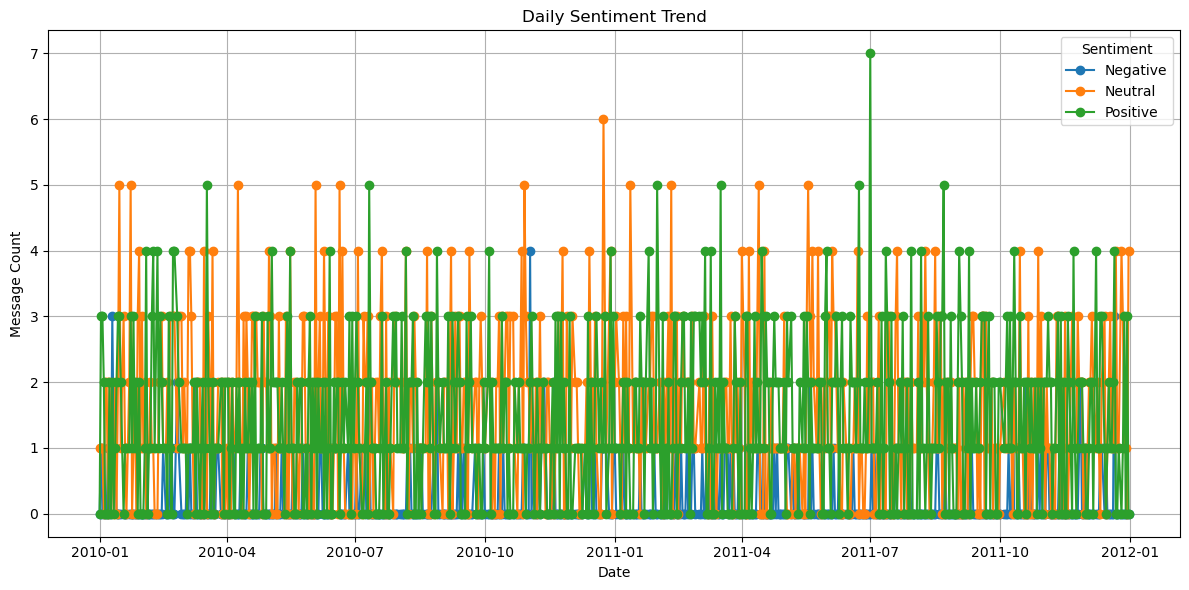

In [26]:

daily_sentiment = df.groupby([df['date'].dt.date, 'Sentiment']).size().unstack(fill_value=0)


daily_sentiment.plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Daily Sentiment Trend')
plt.xlabel('Date')
plt.ylabel('Message Count')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4 : Monthly Sentiment Score Calculation.

## Step 4.1: Assign Scores to Each Message

In [28]:
score_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['Score'] = df['Sentiment'].map(score_map)

## Step 4.2: Extract Month from Date

In [31]:
df['Month'] = df['date'].dt.to_period('M')

## Step 4.3: Aggregate Monthly Scores per Employee

In [32]:
monthly_scores = df.groupby(['from', 'Month'])['Score'].sum().reset_index()
monthly_scores.rename(columns={'from': 'Employee', 'Score': 'Monthly_Score'}, inplace=True)
monthly_scores.head()

,Employee,Month,Monthly_Score
0,bobette.riner@ipgdirect.com,2010-01,2
1,bobette.riner@ipgdirect.com,2010-02,7
2,bobette.riner@ipgdirect.com,2010-03,4
3,bobette.riner@ipgdirect.com,2010-04,2
4,bobette.riner@ipgdirect.com,2010-05,1


# Step 5: Employee Ranking.

 ## Step 5.1: Top Positive and Negative Employees per Month

In [34]:
# Top 3 Positive Employees per Month
top_positive = (
    monthly_scores.sort_values(['Month', 'Monthly_Score', 'Employee'], ascending=[True, False, True])
    .groupby('Month')
    .head(3)
)

# Top 3 Negative Employees per Month
top_negative = (
    monthly_scores.sort_values(['Month', 'Monthly_Score', 'Employee'], ascending=[True, True, True])
    .groupby('Month')
    .head(3)
)

## Step 5.2: View Rankings

In [36]:

print("Top 3 Positive Employees per Month:")
print(top_positive)

print("\nTop 3 Negative Employees per Month:")
print(top_negative)



Top 3 Positive Employees per Month:
                        Employee    Month  Monthly_Score
120      kayne.coulter@enron.com  2010-01              5
168     patti.thompson@enron.com  2010-01              5
24        don.baughman@enron.com  2010-01              4
1    bobette.riner@ipgdirect.com  2010-02              7
73         john.arnold@enron.com  2010-02              7
..                           ...      ...            ...
142      kayne.coulter@enron.com  2011-11              7
22   bobette.riner@ipgdirect.com  2011-11              6
143      kayne.coulter@enron.com  2011-12              5
191     patti.thompson@enron.com  2011-12              5
71           eric.bass@enron.com  2011-12              4

[72 rows x 3 columns]

Top 3 Negative Employees per Month:
                        Employee    Month  Monthly_Score
192      rhonda.denton@enron.com  2010-01              0
96       johnny.palmer@enron.com  2010-01              1
0    bobette.riner@ipgdirect.com  2010-01        

# Step 6: Flight Risk Identification.

## Step 6.1: Flag Employees with ≥ 4 Negative Messages in Any 30-Day Window

In [37]:

negatives = df[df['Sentiment'] == 'Negative'].copy()


negatives.sort_values(['from', 'date'], inplace=True)


flight_risk_flags = []

for emp, group in negatives.groupby('from'):
    dates = group['date'].reset_index(drop=True)
    for i in range(len(dates)):
        window_start = dates[i]
        window_end = window_start + pd.Timedelta(days=30)
        count_in_window = dates[(dates >= window_start) & (dates <= window_end)].count()
        if count_in_window >= 4:
            flight_risk_flags.append(emp)
            break  


flight_risk_employees = list(set(flight_risk_flags))
print("🚨 Flight Risk Employees:")
print(flight_risk_employees)

🚨 Flight Risk Employees:
['rhonda.denton@enron.com', 'johnny.palmer@enron.com', 'patti.thompson@enron.com', 'bobette.riner@ipgdirect.com', 'lydia.delgado@enron.com', 'john.arnold@enron.com', 'sally.beck@enron.com']


# Step 7: Predictive Modeling

## Step 7.1: Feature Engineering

In [38]:

df['Message_Length'] = df['body'].apply(len)

# Monthly aggregation
features = df.groupby(['from', df['date'].dt.to_period('M')]).agg({
    'body': 'count',  
    'Message_Length': 'mean',  
    'Score': 'sum'
}).reset_index()

features.rename(columns={
    'from': 'Employee',
    'body': 'Message_Count',
    'Message_Length': 'Avg_Message_Length',
    'Score': 'Monthly_Score'
}, inplace=True)

## Step 7.2: Train a Linear Regression Model

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


X = features[['Message_Count', 'Avg_Message_Length']]
y = features['Monthly_Score']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

R² Score: 0.4343256660073509
MAE: 1.4623024527372468


## Step 7.3: Visualize Predictions vs Actuals

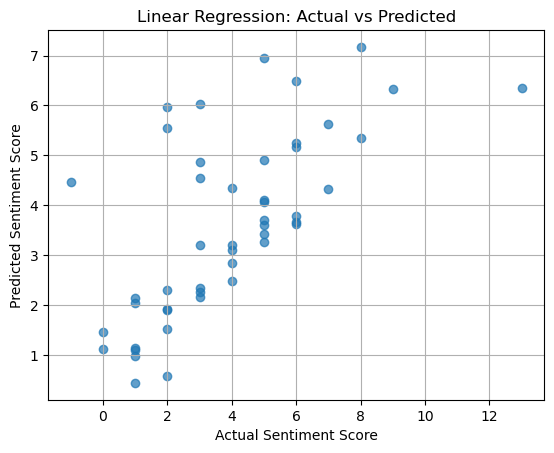

In [40]:

import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Sentiment Score')
plt.ylabel('Predicted Sentiment Score')
plt.title('Linear Regression: Actual vs Predicted')
plt.grid(True)
plt.show()